# Notebook modified from CNES AVISO's Notebook " Search SWOT "

![](https://img.shields.io/badge/CNES_AVISO-Contribution-%20?color=grey&labelColor=blue)

This notebook explains how to search half orbits intersecting a geographical area and make plots.

To run this notebook you will need to download the swath geometries geojson files : [Science phase geometries](https://github.com/SWOT-community/SWOT-Oceanography/blob/main/KaRIn_2kms_science_geometries.geojson) and [Cal/Val phase geometries](https://github.com/SWOT-community/SWOT-Oceanography/blob/main/KaRIn_2kms_calval_geometries.geojson)

## Code Objectives
* Get the numbers of the half orbits intersecting with a geographical area.
* Get the intrested passes from the downloaded data
* Visualise the different variables

## Import + code

In [1]:
import warnings
warnings.filterwarnings('ignore')

import geopandas as gpd
from shapely import geometry

import numpy as np
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import plots
import functions
import glob
import os
import shutil
import pandas as pd
import matplotlib.colors as mcolors

In [2]:
def get_half_orbits_intersect(bbox):
    """Get half orbits that intersect a bounding box.

    Parameters
    ----------
    bbox: 
        the bounding box
        
    Returns
    -------
     gpd.GeoDataFrame:
        A Geopandas dataframe containing intersecting half orbits numbers and geometries
    """
    swath_geometries = gpd.read_file(GEOMETRIES_FILE)

    bbox_polygon = geometry.box(*bbox)

    def _filter_intersect(row, polygon):
        half_orbit_polygon = row.geometry
        return polygon.intersects(half_orbit_polygon)

    select = swath_geometries.apply(_filter_intersect, polygon=bbox_polygon, axis=1)
    return swath_geometries[select]

In [3]:
def plot_geometries(geometries, lon_range, lat_range, title, plot_extent=None):
    fig, ax = plt.subplots(ncols=1, figsize=(6, 4), subplot_kw={'projection': ccrs.PlateCarree()})

    gpd.GeoSeries(geometries.geometry).plot(ax=ax,transform=ccrs.PlateCarree(),alpha=1)
    
    square = patches.Rectangle((lon_range[0], lat_range[0]), lon_range[1]-lon_range[0], lat_range[1]-lat_range[0], edgecolor='orange', facecolor='none', transform=ccrs.PlateCarree())
    ax.add_patch(square)

    ax.set_title(title)
    ax.coastlines()
    if plot_extent:
        ax.set_extent(plot_extent, crs=ccrs.PlateCarree())

## Parameters

Define a geographical area near moorings positions

In [9]:
# Labrador Sea
lon_range = -55.7, -49
lat_range = 45, 54

# lon_range = -55.564, -55.437
# lat_range = 53.376, 53.49

In [11]:
bbox = [lon_range[0], lat_range[0], lon_range[1], lat_range[1]]
plot_extent = [lon_range[0], lon_range[1], lat_range[0], lat_range[1]]

Define the phase

In [14]:
# science, calval
phase = 'science'

Define the geometries file's path to use

In [17]:
GEOMETRIES_FILE = f'KaRIn_2kms_{phase}_geometries.geojson'

## Search for matching half orbits

In [20]:
swath_geoms = get_half_orbits_intersect(bbox)

In [21]:
# swath_geoms['pass_number']

In [24]:
half_orbits = list(swath_geoms['pass_number'])
half_orbits

[18,
 46,
 74,
 89,
 117,
 145,
 173,
 201,
 268,
 296,
 324,
 352,
 367,
 380,
 395,
 423,
 451,
 479,
 507,
 546,
 574]

## Plot geometries

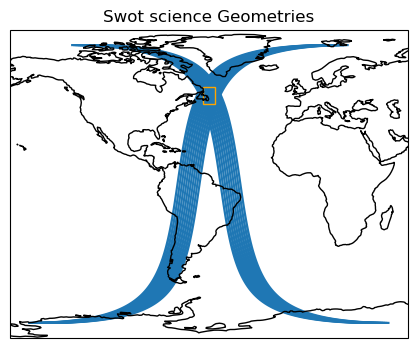

In [27]:
plot_geometries(swath_geoms, lon_range, lat_range, f"Swot {phase} Geometries")

In [130]:
# half_orbit_num = 46, 201, 479
# half_orbit_num = 20

half_orbit_num = 507
plot_geometries(swath_geoms[swath_geoms['pass_number']==half_orbit_num], lon_range, lat_range, f"Swot {phase} Geometry, half orbit={half_orbit_num}", plot_extent)

In [27]:
bathy_data = 'GEBCO_14_May_2025_b03991ce039e/gebco_2024_n75.0_s42.0_w-80.0_e-40.0.nc'
bathy = xr.open_dataset(bathy_data) 

## Plot swath

In [30]:
%matplotlib qt

In [32]:
fig, ax, rect = plots.figure(figsize=(5, 5),nrows=1,ncols=1,region=[-65, -45, 43, 63])
# fig, ax, rect = plots.figure(figsize=(4, 4),nrows=1,ncols=1,region=[-60, -47, 47, 60])

swath_geoms[swath_geoms['pass_number']==half_orbit_num].plot(ax=ax, transform=ccrs.PlateCarree(),alpha=0.4, color='yellow', zorder=3)

norm = mcolors.PowerNorm(gamma=0.25, vmin=10, vmax=2500)
BP = (-1*bathy.elevation).plot.pcolormesh(ax=ax, transform=ccrs.PlateCarree(), norm=norm, cmap='Blues', add_colorbar=False)

BC = (-1*bathy.elevation).plot.contour(ax=ax, transform=ccrs.PlateCarree(), colors='snow', alpha=0.5, levels=[500, 2500, 3000, 4000], linewidths=0.5)
ax.clabel(BC, levels=[2500, 3000,4000], inline=True, fontsize=5, colors='snow', zorder=1)

ax.text(-47.5, 62, "Greenland",
        transform=ccrs.PlateCarree(),
        horizontalalignment='center',
        fontsize=4, zorder=4)

ax.text(-61, 52.5, "Labrador",
        transform=ccrs.PlateCarree(),
        horizontalalignment='center',
        fontsize=6, zorder=4)

ax.text(-56, 48.6, "Newfoundland",transform=ccrs.PlateCarree(),
        horizontalalignment='center', fontsize=4, zorder=4)

ax.text(-52, 46, "Grand",transform=ccrs.PlateCarree(),
        horizontalalignment='center', fontsize=4, zorder=4, c='white', fontweight='bold')
ax.text(-52, 45.8, "Banks",transform=ccrs.PlateCarree(),
        horizontalalignment='center', fontsize=4, zorder=4, c='white', fontweight='bold')

ax.text(-61.2, 60, "pass 46 ",transform=ccrs.PlateCarree(),
        horizontalalignment='center', rotation=-70, fontsize=8, zorder=4, c='snow')
ax.text(-53, 57.5, "pass 201 ",transform=ccrs.PlateCarree(),
        horizontalalignment='center', rotation=65, fontsize=8, zorder=4, c='snow')
ax.text(-50.7, 57.5, "pass 479 ",transform=ccrs.PlateCarree(),
        horizontalalignment='center', rotation=65, fontsize=8, zorder=4, c='snow')



mo1 = ax.plot(-53.00083, 50.74967, 'o', c='b', label='SWOT1-01', markersize=2, transform=ccrs.PlateCarree(), zorder=4)[0]  # position of mooring 1
mo2 = ax.plot(-53.26417, 50.16467, 'o', c='fuchsia', label='SWOT2-01', markersize=2, transform=ccrs.PlateCarree(), zorder=4)[0]  # position of mooring 2
mo3 = ax.plot(-52.58427, 49.74992, 'o', c='cyan', label='SWOT3-01', markersize=2, transform=ccrs.PlateCarree(), zorder=4)[0]  # position of mooring 3

x=[-55.03333, -55.16233, -55.43833, -55.56367]
y=[53.53333,  53.491, 53.40833, 53.37517]
lcc = ax.plot(x,y, 'g', label='LCC moorings', transform=ccrs.PlateCarree(), zorder=4)[0]

ax.legend(handles=[lcc, mo1, mo2, mo3], fontsize=6, loc = 'upper right', bbox_to_anchor=(1.25, 1))
ax.tick_params(right=False, labelright=False)

lon_range = -56, -53
lat_range = 50.4, 55.4
square = patches.Rectangle((lon_range[0], lat_range[0]), lon_range[1]-lon_range[0], lat_range[1]-lat_range[0], edgecolor='snow', facecolor='none', transform=ccrs.PlateCarree())
ax.add_patch(square)

plots.axis_shape(ax, rect, addCoastline=True, addCheckerboard=False)

plt.show()
# fig.savefig("Swath_SP+mooring_loc.png", dpi= 300)  